<a href="https://colab.research.google.com/github/marta-0/medical_mnist/blob/main/notebooks/Occlusion_sensitivity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Occlusion sensitivity

In [1]:
import zipfile
import random

from PIL import Image

import numpy as np
import math
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf

random.seed(1)
np.random.seed(1)
tf.random.set_seed(1)

In [2]:
!git clone https://github.com/apolanco3225/Medical-MNIST-Classification

Cloning into 'Medical-MNIST-Classification'...
remote: Enumerating objects: 58532, done.
remote: Total 58532 (delta 0), reused 0 (delta 0), pack-reused 58532
Receiving objects: 100% (58532/58532), 77.86 MiB | 38.14 MiB/s, done.
Resolving deltas: 100% (506/506), done.
Checking out files: 100% (58959/58959), done.


In [3]:
labels = ['AbdomenCT', 'BreastMRI', 'CXR', 'ChestCT', 'Hand', 'HeadCT']

In [7]:
with zipfile.ZipFile('/content/models.zip','r') as zippedfile:
  zippedfile.extractall()

model_baseline = tf.keras.models.load_model('models/baseline')
model_gmp = tf.keras.models.load_model('models/gmp')
model_gmp_hflip_rot180 = tf.keras.models.load_model('models/gmp_hflip_rot180')
model_hflip = tf.keras.models.load_model('models/hflip')
model_rot180 = tf.keras.models.load_model('models/rotate180')
model_d01 = tf.keras.models.load_model('models/dropout_01')
model_d2_01 = tf.keras.models.load_model('models/dropout_2_01')
model_best = tf.keras.models.load_model('models/gmp+hflip+rot180+bn128')
model_best_var_sizes = tf.keras.models.load_model('models/best_various_sizes')
model_gmp_var_sizes = tf.keras.models.load_model('models/gmp_various_sizes')
model_gmp_hflip = tf.keras.models.load_model('models/gmp_hflip')
model_baseline_occ = tf.keras.models.load_model('models/baseline_occ')
model_best_occ = tf.keras.models.load_model('models/best_occ')
model_hflip_occ = tf.keras.models.load_model('models/hflip_occ')
model_d2_01_occ = tf.keras.models.load_model('models/dropout_2_01_occ')
model_gmp_occ = tf.keras.models.load_model('models/gmp_occ')

Function calculating occlusion sensitivity:

In [65]:
def occlusion_sensitivity(img, model, label, occ_size=16, stride=2, occ_pixel = 0, show_steps=False, show_occ_img=False):
    img_arr = np.asarray(img, dtype=np.int16)
    width, height = img_arr.shape

    output_height = math.ceil((height - occ_size) / stride + 1)
    output_width = math.ceil((width - occ_size) / stride + 1)
    heatmap = np.zeros((output_height, output_width))

    if show_occ_img:
      plt.figure(figsize=(20, 300))
      pos = 1

    for h in range(output_height):
        for w in range(output_width):
            occ_img = img_arr.copy()
            h_start = h * stride
            w_start = w * stride
            h_end = min(height, h_start + occ_size)
            w_end = min(width, w_start + occ_size)
            occ_img[h_start:h_end,w_start:w_end] = occ_pixel

            occ_img = occ_img / np.max(occ_img)
            occ_img = np.expand_dims(occ_img, axis=2)
            occ_img = np.expand_dims(occ_img, axis=0)

            if show_occ_img:
              plt.subplot(201, 12, pos)
              plt.imshow(np.squeeze(occ_img), cmap='gray')
              plt.xticks([])
              plt.yticks([])
              pos = pos + 1

            pred = model.predict(occ_img)
            prob = pred[0][label]

            heatmap[h,w] = 1 - prob

    heatmap_img = Image.fromarray(np.uint8(heatmap * 255))
    heatmap_resized = heatmap_img.resize((width, height))
    heatmap_resized = np.asarray(heatmap_resized, dtype=np.int16) / 255
    mask = heatmap_resized == 0

    if show_steps:
      plt.figure(figsize=(15,4))
      plt.subplot(1,3,1)
      plt.imshow(img_arr, cmap='gray')
      plt.subplot(1,3,2)
      sns.heatmap(heatmap, cmap='viridis', vmin=0, vmax=1.0, cbar_kws={'ticks':[0, 0.2, 0.4, 0.6, 0.8, 1.0]})
      plt.subplot(1,3,3)

    sns.set(font_scale=2)
    sns.set_style("dark")
    sns.heatmap(heatmap_resized, zorder=2, yticklabels=False, xticklabels=False, mask=mask, cmap='viridis', vmin=0, vmax=1.0, cbar_kws={'ticks':[0, 0.2, 0.4, 0.6, 0.8, 1.0]})
    plt.imshow(img_arr, zorder=1, cmap='gray');

Function showing multiple occlusion sensitivity results in one figure:

In [5]:
def show_occlusions(images, models, titles, classes, in_row, occ_size=16, stride=2, figsize=(30,5)):
  plt.figure(figsize=figsize)

  for i, image in enumerate(images):
    if isinstance(image, str):
      image = Image.open(image)

    plt.subplot(math.ceil(len(models)/in_row), in_row, i+1)
    occlusion_sensitivity(image, models[i], label=classes[i], occ_size=occ_size, stride=stride)
    if titles:
      plt.title(titles[i], fontsize=20)

Function showing predicted probabilities:

In [42]:
def prepare_and_predict(img, model, label, show_all=False):
  img = img.resize((64,64))
  img = img.convert('L')
  img = np.asarray(img, dtype=np.int16)
  img = img / 255
  img = np.expand_dims(img, axis=-1)
  img_X = np.expand_dims(img, axis=0)

  pred = model.predict(img_X)

  if show_all:
    print('AbdomenCT:', pred[0,0], 'BreastMRI:', pred[0,1], 'CXR:', pred[0,2], 'ChestCT:', pred[0,3], 'Hand:', pred[0,4], 'HeadCT:', pred[0,5])

  else:
    return np.argmax(pred[0]), np.max(pred[0]), pred[0, label]

Function showing model mistakes occlusion sensitivity:

In [52]:
def mistakes_occlusions(model, images, num_mistakes, true_labels):
  plt.figure(figsize=(15,num_mistakes*4))

  for i, img in enumerate(images):
    img = Image.open(img)
    max_label, max_prob, true_prob = prepare_and_predict(img, model, true_labels[i])

    plt.subplot(num_mistakes, 3, (i*3)+1)
    plt.imshow(np.asarray(img, dtype=np.int16), cmap='gray')
    plt.title('True: ' + labels[true_labels[i]], fontsize=20)
    plt.axis('off') 
    plt.subplot(num_mistakes, 3, (i*3)+2)
    occlusion_sensitivity(img, model, true_labels[i])
    plt.title('Pred: ' + str(labels[true_labels[i]]) + '\nP: ' + str(round(true_prob,3)), fontsize=20)
    plt.subplot(num_mistakes, 3, (i*3)+3)
    occlusion_sensitivity(img, model, max_label)
    plt.title('Pred: ' + str(labels[max_label]) + '\nP: ' + str(round(max_prob,3)), fontsize=20)

  plt.tight_layout();

## Different models, different occlusion sizes

Occlusion sensitivity for different models - comparison of impact of different occlusion sizes using AbdomenCT example:

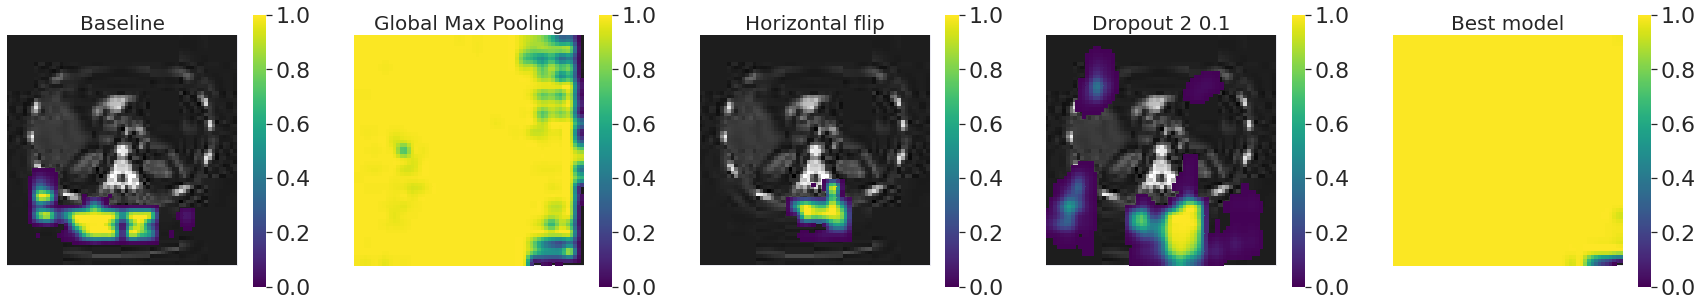

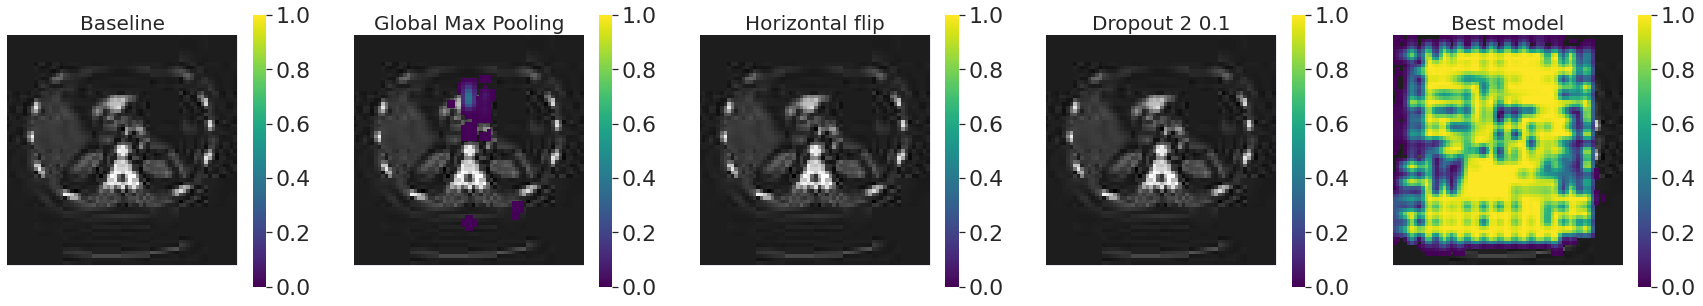

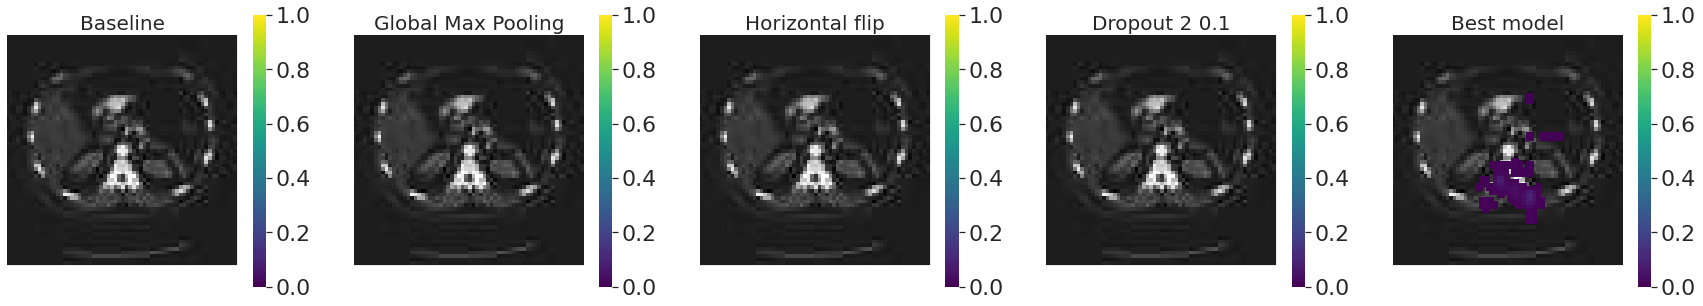

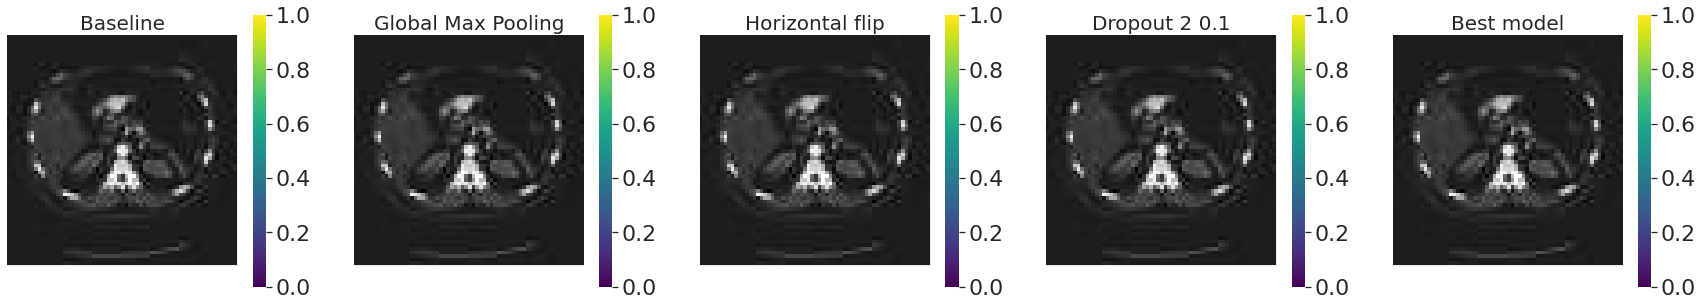

In [ ]:
models = [model_baseline, model_gmp, model_hflip, model_d2_01, model_best]
titles = ['Baseline', 'Global Max Pooling', 'Horizontal flip', 'Dropout 2 0.1', 'Best model']
classes = [0] * 5
img_paths = ['/content/Medical-MNIST-Classification/resized/AbdomenCT/000000.jpeg'] * 5

show_occlusions(img_paths, models, titles, classes, 5)
show_occlusions(img_paths, models, titles, classes, 5, occ_size=8)
show_occlusions(img_paths, models, titles, classes, 5, occ_size=4)
show_occlusions(img_paths, models, titles, classes, 5, occ_size=2)

## Best model - occlusion sensitivity example

x and yticks demonstrate how the resulting heatmap is smaller than the original image. The heatmap is resized and put on the original image with zeros masked out.

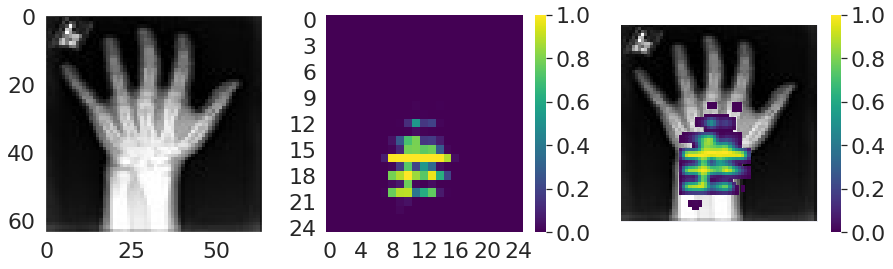

In [66]:
occlusion_sensitivity(Image.open('/content/Medical-MNIST-Classification/resized/Hand/009999.jpeg'), model_best, 4, show_steps=True)

## Best model - different classes

Occlusion sensitivity for best model - one example from each class. 

Occ_size = 16, stride = 2

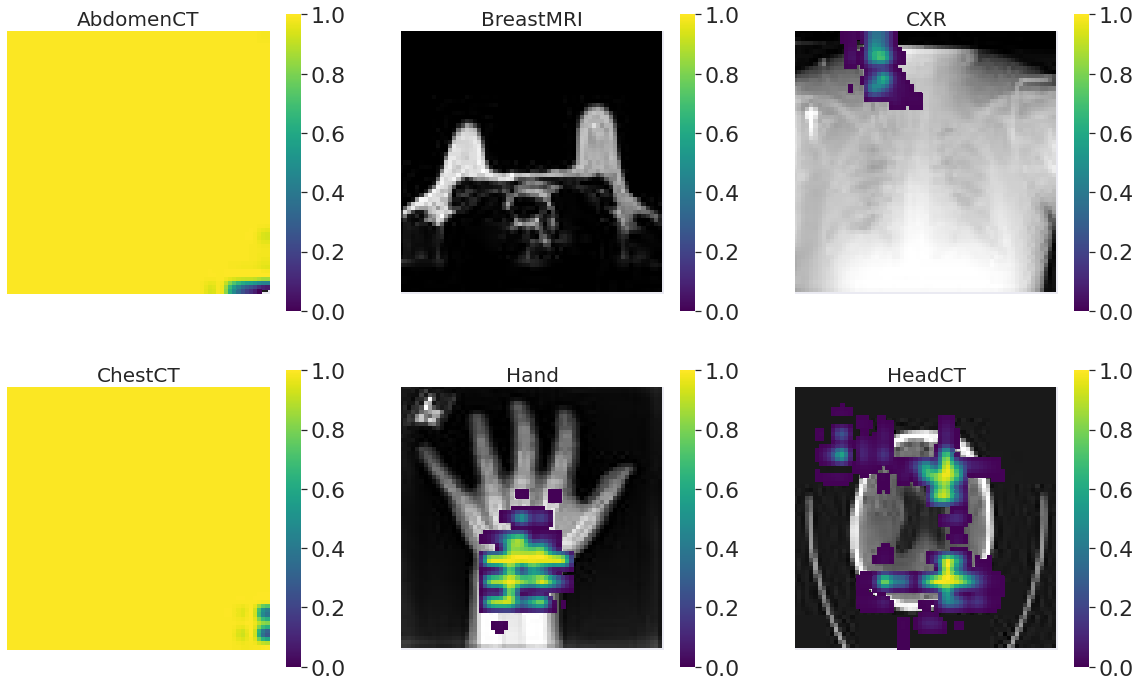

In [55]:
models = [model_best] * 6
classes = list(range(7))
img_paths = ['/content/Medical-MNIST-Classification/resized/AbdomenCT/000000.jpeg',
              '/content/Medical-MNIST-Classification/resized/BreastMRI/008953.jpeg',
              '/content/Medical-MNIST-Classification/resized/CXR/009999.jpeg',
              '/content/Medical-MNIST-Classification/resized/ChestCT/009999.jpeg',
              '/content/Medical-MNIST-Classification/resized/Hand/009999.jpeg',
              '/content/Medical-MNIST-Classification/resized/HeadCT/009999.jpeg']

show_occlusions(img_paths, models, labels, classes, 3, figsize=(20,12))

## Best model - mistakes

In [43]:
prepare_and_predict(Image.open('/content/Medical-MNIST-Classification/resized/CXR/006796.jpeg'), model_best, 2, show_all=True)
prepare_and_predict(Image.open('/content/Medical-MNIST-Classification/resized/Hand/005077.jpeg'), model_best, 4, show_all=True)
prepare_and_predict(Image.open('/content/Medical-MNIST-Classification/resized/Hand/008806.jpeg'), model_best, 4, show_all=True)

AbdomenCT: 1.0111302e-09 BreastMRI: 3.056428e-09 CXR: 0.075800836 ChestCT: 5.46536e-19 Hand: 0.9241991 HeadCT: 5.487938e-10
AbdomenCT: 9.390695e-14 BreastMRI: 0.99720144 CXR: 2.2739892e-09 ChestCT: 1.1520801e-14 Hand: 0.0027985747 HeadCT: 3.2863638e-09
AbdomenCT: 1.2294309e-07 BreastMRI: 0.79408896 CXR: 9.827651e-05 ChestCT: 1.0786939e-11 Hand: 0.20546973 HeadCT: 0.00034294464


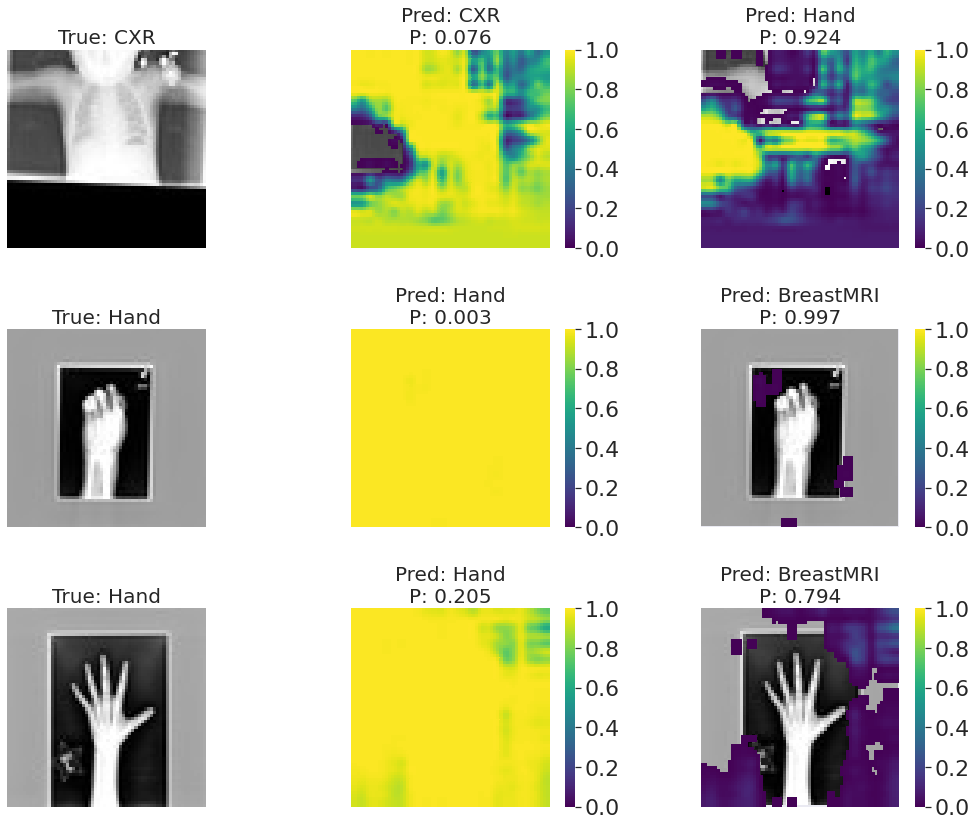

In [34]:
images = ['/content/Medical-MNIST-Classification/resized/CXR/006796.jpeg',
          '/content/Medical-MNIST-Classification/resized/Hand/005077.jpeg',
          '/content/Medical-MNIST-Classification/resized/Hand/008806.jpeg']
          
mistakes_occlusions(model_best, images, 3, [2,4,4])

## Best model trained on different sizes images generator - mistakes

In [48]:
prepare_and_predict(Image.open('/content/Medical-MNIST-Classification/resized/Hand/009865.jpeg'), model_best_var_sizes, 4, show_all=True)
prepare_and_predict(Image.open('/content/Medical-MNIST-Classification/resized/Hand/003646.jpeg'), model_best_var_sizes,4, show_all=True)
prepare_and_predict(Image.open('/content/Medical-MNIST-Classification/resized/BreastMRI/000623.jpeg'), model_best_var_sizes, 1, show_all=True)
prepare_and_predict(Image.open('/content/Medical-MNIST-Classification/resized/AbdomenCT/002248.jpeg'), model_best_var_sizes, 0, show_all=True)
prepare_and_predict(Image.open('/content/Medical-MNIST-Classification/resized/BreastMRI/006952.jpeg'), model_best_var_sizes, 1, show_all=True)

AbdomenCT: 6.875295e-16 BreastMRI: 3.690977e-08 CXR: 0.8418294 ChestCT: 2.9767655e-16 Hand: 0.15817054 HeadCT: 8.92304e-12
AbdomenCT: 5.4270753e-14 BreastMRI: 5.7772953e-12 CXR: 0.7418236 ChestCT: 1.1529068e-21 Hand: 0.25817636 HeadCT: 9.16258e-14
AbdomenCT: 1.4516307e-12 BreastMRI: 0.23813553 CXR: 0.51289946 ChestCT: 6.401255e-12 Hand: 0.24896279 HeadCT: 2.1959563e-06
AbdomenCT: 0.49955857 BreastMRI: 8.406869e-17 CXR: 5.282418e-07 ChestCT: 4.1769744e-15 Hand: 0.50044096 HeadCT: 4.64067e-09
AbdomenCT: 2.4188174e-15 BreastMRI: 0.09106791 CXR: 0.00020801593 ChestCT: 3.3702038e-17 Hand: 0.90872407 HeadCT: 2.590894e-10


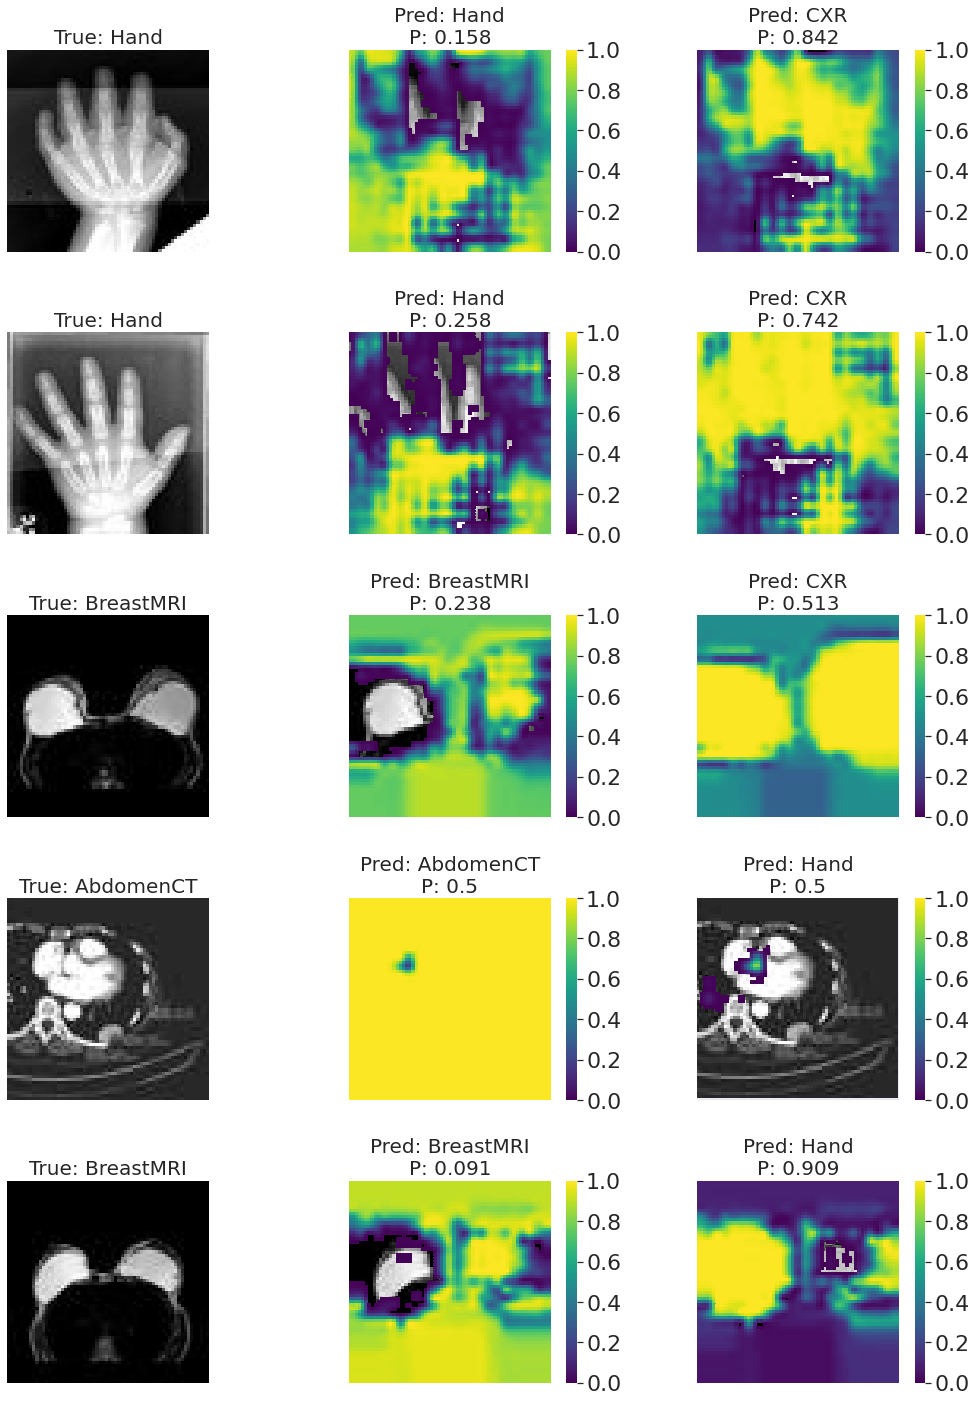

In [53]:
images = ['/content/Medical-MNIST-Classification/resized/Hand/009865.jpeg',
          '/content/Medical-MNIST-Classification/resized/Hand/003646.jpeg',
          '/content/Medical-MNIST-Classification/resized/BreastMRI/000623.jpeg',
          '/content/Medical-MNIST-Classification/resized/AbdomenCT/002248.jpeg',
          '/content/Medical-MNIST-Classification/resized/BreastMRI/006952.jpeg']

mistakes_occlusions(model_best_var_sizes, images, 5, [4,4,1,0,1])

## Models trained on the occluded images generator

First row: occ_size = 16, stride = 2

Second row: values of occ_size have been found manually, stride = 2

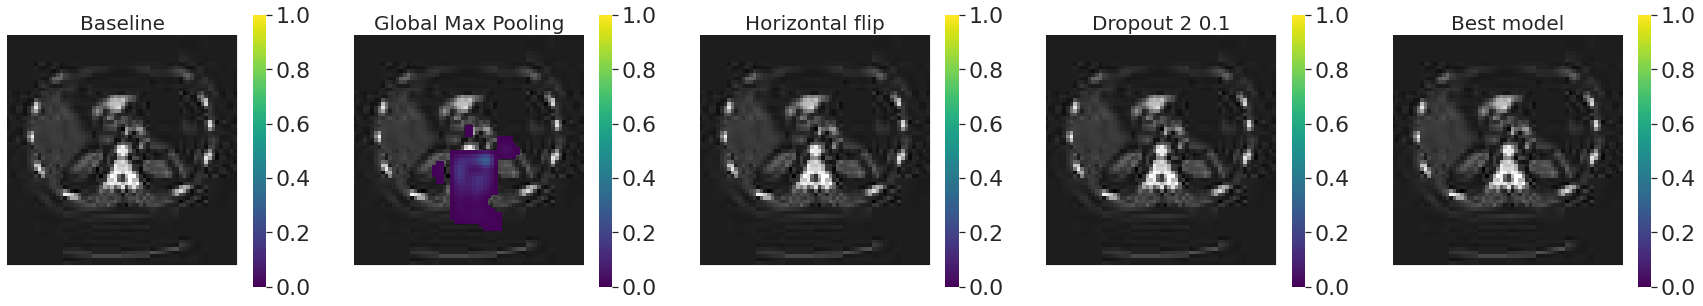

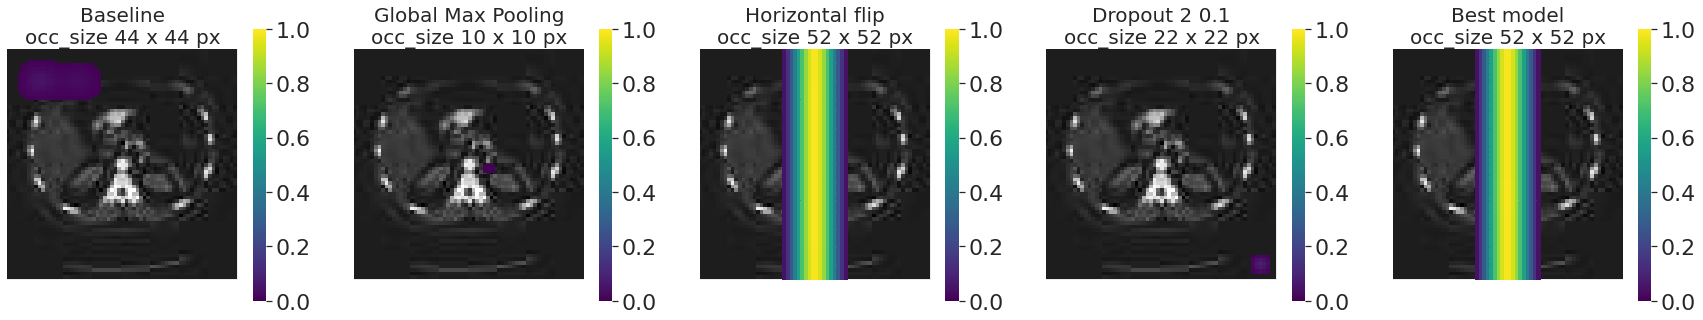

In [ ]:
models = [model_baseline_occ, model_gmp_occ, model_hflip_occ, model_d2_01_occ, model_best_occ]
titles = ['Baseline', 'Global Max Pooling', 'Horizontal flip', 'Dropout 2 0.1', 'Best model']
classes = [0] * 5
img_paths = ['/content/Medical-MNIST-Classification/resized/AbdomenCT/000000.jpeg'] * 5

show_occlusions(img_paths, models, titles, classes, 5)


plt.figure(figsize=(30,5))
titles_w_occ_size = ['Baseline\nocc_size 44 x 44 px', 'Global Max Pooling\nocc_size 10 x 10 px', 'Horizontal flip\nocc_size 52 x 52 px', 
                     'Dropout 2 0.1\nocc_size 22 x 22 px', 'Best model\nocc_size 52 x 52 px']
occ_sizes = [44, 10, 52, 22, 52]

for i, model in enumerate(models):
  plt.subplot(1,5,i+1)
  occlusion_sensitivity(Image.open(img_paths[0]), model, 0, occ_size=occ_sizes[i])
  plt.title(titles_w_occ_size[i], fontsize=20)

## Models with Dropout

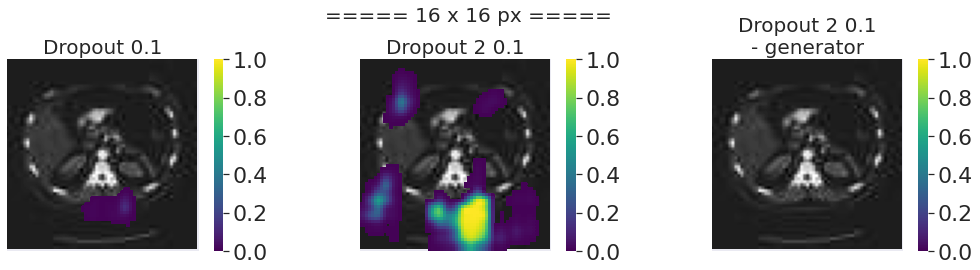

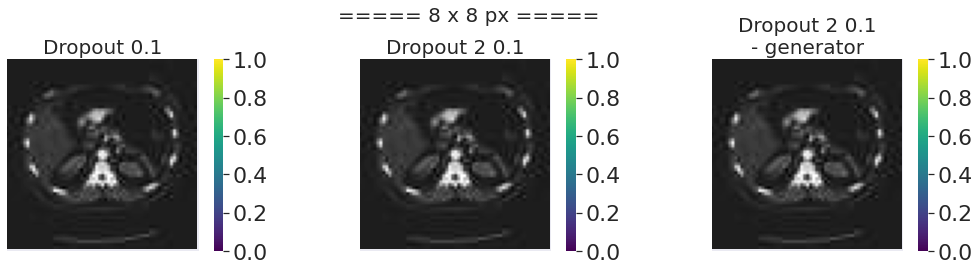

In [ ]:
models = [model_d01, model_d2_01, model_d2_01_occ]
titles = ['Dropout 0.1', 'Dropout 2 0.1', 'Dropout 2 0.1\n- generator']
classes = [0] * 3
img_paths = ['/content/Medical-MNIST-Classification/resized/AbdomenCT/000000.jpeg'] * 3

show_occlusions(img_paths, models, titles, classes, 3, figsize=(15,4))
plt.suptitle('===== 16 x 16 px =====', fontsize=20)
plt.tight_layout(w_pad=1.2)
show_occlusions(img_paths, models, titles, classes, 3, occ_size=8, figsize=(15,4))
plt.suptitle('===== 8 x 8 px =====', fontsize=20)
plt.tight_layout(w_pad=1.2)

## Model Horizontal flip - rotated image

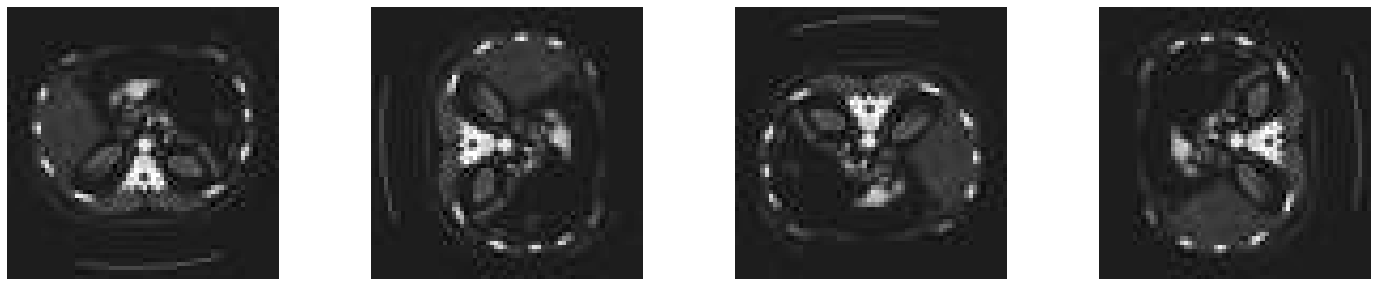

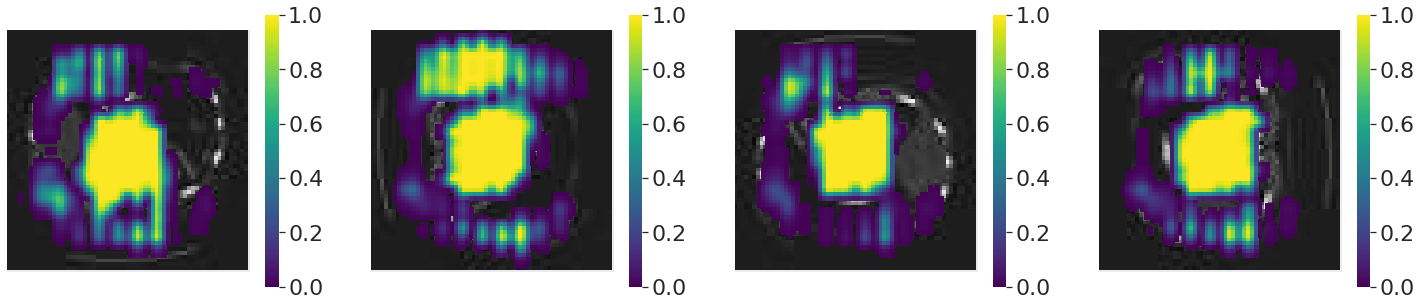

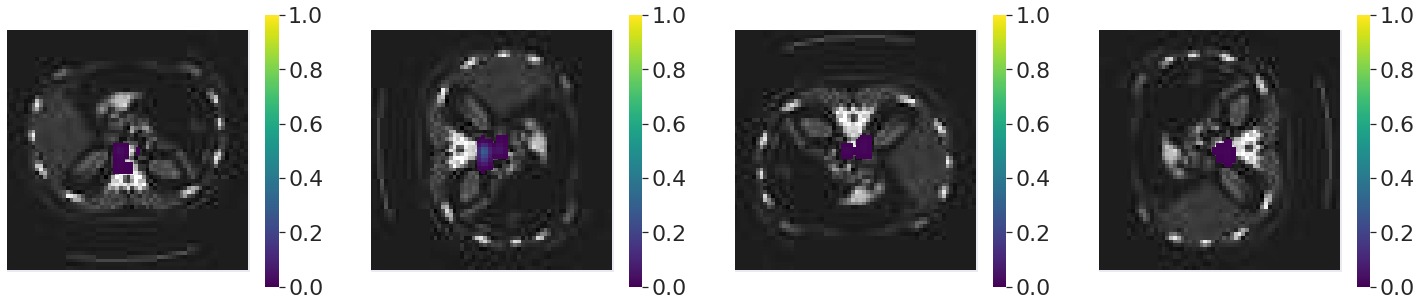

In [ ]:
image = Image.open('/content/Medical-MNIST-Classification/resized/AbdomenCT/000000.jpeg')
images = [image, image.rotate(270), image.rotate(180), image.rotate(90)]
models = [model_rot180] * 4
classes = [0] * 4
titles = []

plt.figure(figsize=(25,5))
for i, _img in enumerate(images):
  plt.subplot(1,4,i+1)
  plt.imshow(np.asarray(_img, dtype=np.int16), cmap='gray')
  plt.axis('off')

show_occlusions(images, models, titles, classes, 4, figsize=(25,5))
show_occlusions(images, models, titles, classes, 4, figsize=(25,5), occ_size=8)

## Global Max Pooling - different occluding pixel

Comparison of different occluding pixel influence on occlusion sensitivity for Global Max Pooling model and Global Max Pooling model trained on the different size images generator.

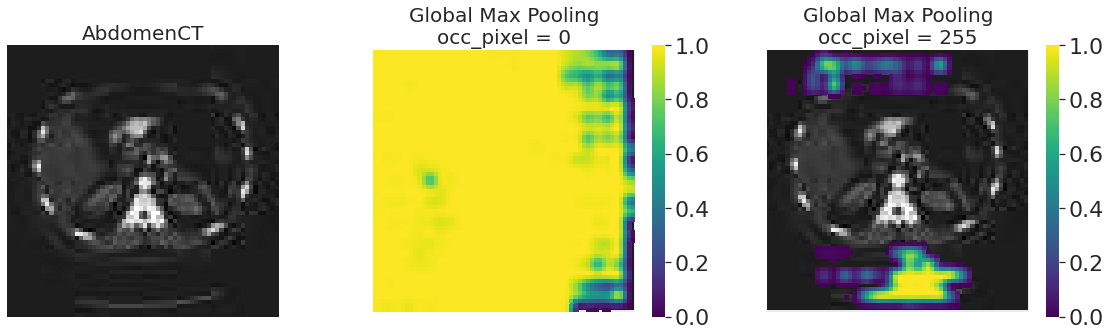

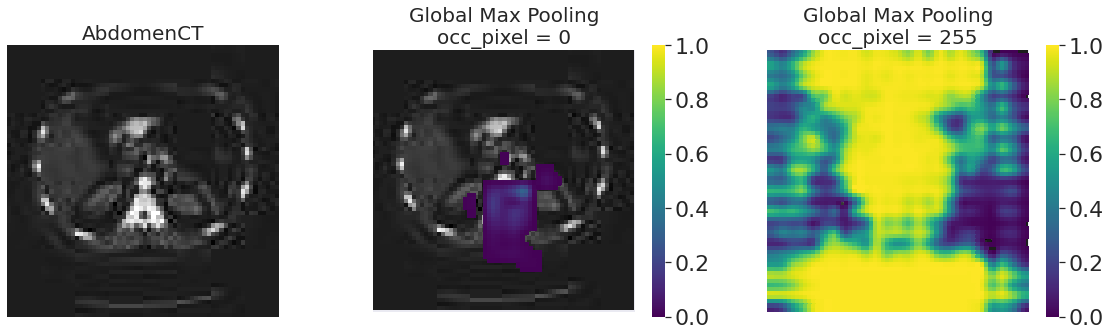

In [57]:
image = Image.open('/content/Medical-MNIST-Classification/resized/AbdomenCT/000000.jpeg')

for model in [model_gmp, model_gmp_occ]:
  plt.figure(figsize=(20,5))
  plt.subplot(1,3,1)
  plt.imshow(np.asarray(image, dtype=np.int16), cmap='gray')
  plt.title('AbdomenCT', fontsize=20)
  plt.axis('off')
  plt.subplot(1,3,2)
  occlusion_sensitivity(image, model, 0, occ_pixel=0)
  plt.title('Global Max Pooling\nocc_pixel = 0', fontsize=20)
  plt.subplot(1,3,3)
  occlusion_sensitivity(image, model, 0, occ_pixel=255)
  plt.title('Global Max Pooling\nocc_pixel = 255', fontsize=20);

## Baseline

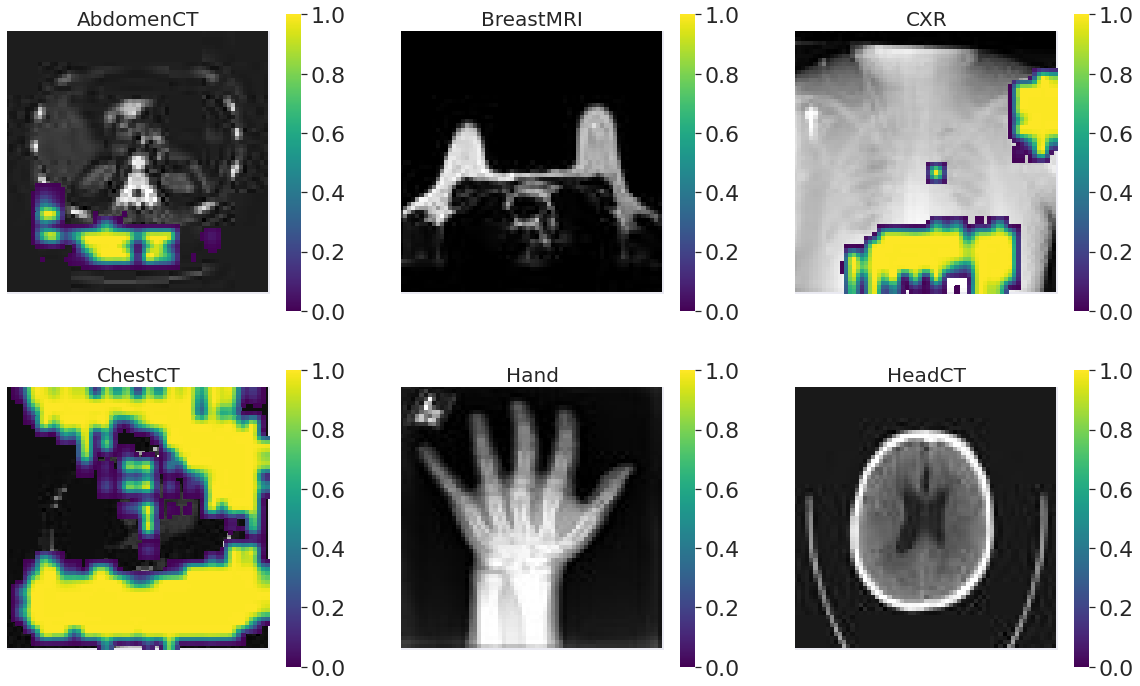

In [56]:
models = [model_baseline] * 6
classes = list(range(7))
img_paths = ['/content/Medical-MNIST-Classification/resized/AbdomenCT/000000.jpeg',
              '/content/Medical-MNIST-Classification/resized/BreastMRI/008953.jpeg',
              '/content/Medical-MNIST-Classification/resized/CXR/009999.jpeg',
              '/content/Medical-MNIST-Classification/resized/ChestCT/009999.jpeg',
              '/content/Medical-MNIST-Classification/resized/Hand/009999.jpeg',
              '/content/Medical-MNIST-Classification/resized/HeadCT/009999.jpeg']

show_occlusions(img_paths, models, labels, classes, 3, figsize=(20,12))

## Baseline - examples for which large occ_size is needed to affect the predictions

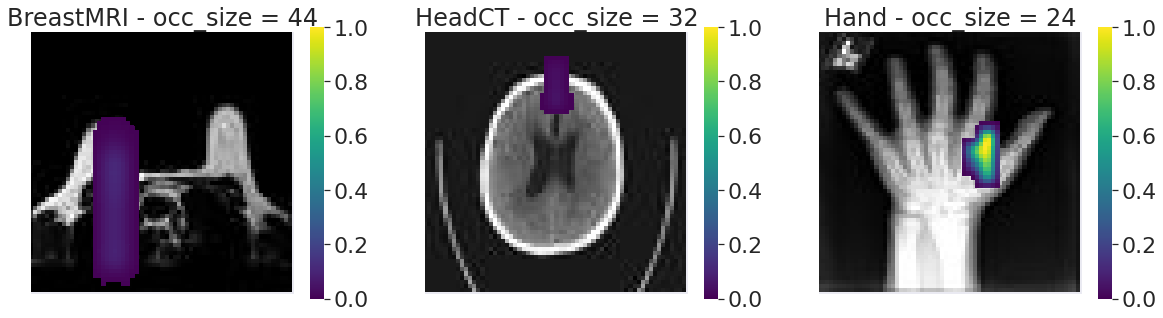

In [58]:
plt.figure(figsize=(20,5))
plt.subplot(1,3,1)
image = Image.open('/content/Medical-MNIST-Classification/resized/BreastMRI/008953.jpeg')
occlusion_sensitivity(image, model_baseline, label=1, occ_size=44)
plt.title('BreastMRI - occ_size = 44')
plt.subplot(1,3,2)
image = Image.open('/content/Medical-MNIST-Classification/resized/HeadCT/009999.jpeg')
occlusion_sensitivity(image, model_baseline, label=5, occ_size=32)
plt.title('HeadCT - occ_size = 32')
plt.subplot(1,3,3)
image = Image.open('/content/Medical-MNIST-Classification/resized/Hand/009999.jpeg')
occlusion_sensitivity(image, model_baseline, label=4, occ_size=24)
plt.title('Hand - occ_size = 24');